# Sports Networks: Limits of PageRank-based ranking methods in sports data
Click on `Run/Run All Cells` before starting (ensure that the collapsed cells are executed). 

In [57]:
# Use cached synthetic data from disk
USE_CACHED_SYNTHETIC_DATA = True
OVERWRITE_CACHED_SYNTHETIC_DATA = True # Disable if you want to make local changes without removing cached data

In [58]:
FIGSIZE = [9.5, 6.5]

In [59]:
import math, random, itertools
import os

import pandas as pd
import numpy as np
from copy import deepcopy
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

from scipy.stats import rankdata
from scipy.stats.mstats import kendalltau
    
from random import choices, sample

from tqdm.notebook import trange, tqdm

In [60]:
#############################################################################################
# configuration expansion

def expand_configuration(config):
    experiments = []

    for n_teams in config["n_teams"]:

        for fitness_d in _expand_fitness(n_teams, config["fitness"]):

            for model_d in _expand_model(config["model"]):

                for fraction_games_per_season in config["fraction_games_per_season"]: 
                                        
                    if config["fix_schedule_over_season"]:
                        if config["schedule"] == "graph":
                            schedule = generate_synthetic_sports_schedule_graph(n_teams, fraction_games_per_season)
                        elif config["schedule"] == "roundrobin":
                            schedule = generate_synthetic_sports_schedule_roundrobin(n_teams, fraction_games_per_season)
                        else:
                            raise ValueError(f"unknown schedule type: {config['schedule']}")
                    else:
                        schedule = None
                        
                    for unexpected_result in  _expand_handle_unexpected_results(config["remove_unexpected"]):       
                        
                        for season in range(config["n_seasons"]): # repetition
                            d = {
                                "n_teams": n_teams,
                                **fitness_d,
                                **model_d,
                                "fraction_games_per_season": fraction_games_per_season,
                                "season": season,
                                "schedule": schedule,
                                "remove_unexpected_mode": unexpected_result["mode"],
                                "remove_unexpected_fraction_eta": unexpected_result["fraction_eta"]
                            }
                            experiments.append(d)

    return experiments


def _expand_handle_unexpected_results(unexpected_config):
    
    exps = []
    for unexpected in unexpected_config:
        for mode, fraction_eta in itertools.product(unexpected["mode"], unexpected["fraction_eta"]):
            d = {
                "mode": mode,
                "fraction_eta": fraction_eta
            }
            exps.append(d)
    return exps


def _expand_fitness(n_teams, fitness_config):
    
    fitness_exp = []
    
    for fitness in fitness_config:
        if fitness["type"] == "linear":
            d = {
                "fitness_type": "linear",
                "fitness_values": linear_fitness(N=n_teams) 
            }
            
        elif fitness["type"] == "nonlinear":
            fitness_values = []
            for alpha, beta, gamma in itertools.product(fitness["alpha"], fitness["beta"], fitness["gamma"]):
                fitness_values += []
                
                d = {
                    "fitness_type": "nonlinear",
                    "fitness_nonlinear_alpha": alpha,
                    "fitness_nonlinear_beta": beta,
                    "fitness_nonlinear_gamma": gamma,                    
                    "fitness_values": nonlinear_fitness(N=n_teams, alpha=alpha, beta=beta, gamma=gamma)
                }
        else:
            raise ValueError(f"unknown fitness: {fitness}")
        
        fitness_values_inv = [-fitness_value for fitness_value in d["fitness_values"]]
        gt_ranking = rankdata(fitness_values_inv, method='min')        
        gt_ranking = [{"team": team_id, "rank": rank, "score": score} for team_id, (rank, score) in enumerate(zip(gt_ranking, d["fitness_values"]))]
        gt_ranking = sorted(gt_ranking, key=lambda k: k["rank"])
        d["gt_ranking"] = gt_ranking
        
        fitness_exp.append(d)
    
    return fitness_exp


def _expand_model(model_config):
    
    model_exp = []
    
    for model in model_config:
        if model["type"] == "logistic":
            for H, delta in itertools.product(model["H"], model["delta"]):
                d = {
                    "model": "logistic",
                    "model_logistic_H": H,
                    "model_logistic_delta": delta
                }
                model_exp.append(d)
        elif model["type"] == "softmax":
            for H, delta in itertools.product(model["H"], model["delta"]):
                d = {
                    "model": "softmax",
                    "model_logistic_H": H,
                    "model_logistic_delta": delta
                }
                model_exp.append(d)
            
        else:
            raise ValueError(f"unknown model: {model}")
        
    return model_exp



#############################################################################################
# fitness levels

def linear_fitness(N):
    return [(i-0.5)/N  for i in range(1, N+1)]

def nonlinear_fitness(N, alpha, beta, gamma):
    
    gamma0 = 0 if gamma == "fix" else gamma 
    
    fitness_values = [beta * (((i-0.5)/N) ** alpha) + gamma0  for i in range(1, N+1)]
    
    if gamma == "fix": # choose gamma such that avg fitness level == 0.5
        gamma0 = 0.5 - sum(fitness_values) / N
        fitness_values = [x + gamma0 for x in fitness_values]
        
    return fitness_values

#############################################################################################
# models

def logistic_model(f_i, f_j, H, delta):
    # f_i fitness value of team i (home team)
    # f_j fitness value of team j (away team)
    # H: home advantage
    # delta: randomness factor
    return sigmoid((f_i - f_j + H)/delta)

# in the paper math formula, I think they have an additional ^-1 which is wrong
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(vec):
    ex = np.exp(vec)
    return ex / np.sum(ex, axis=0)

def softmax_model_win(delta_w, H, delta):
    return (delta_w + H) / delta

def softmax_model_lose(delta_w, H, delta):
    return -(delta_w + H) / delta

def softmax_model_draw(delta_w, H):
    return -((delta_w + H) * (delta_w + H))

def softmax_model(f_i, f_j, H, delta):
    delta_w = f_i - f_j
    P_win = softmax_model_win(delta_w, H, delta)
    P_lose = softmax_model_lose(delta_w, H, delta)
    P_draw = softmax_model_draw(delta_w, H)
    P_vec = np.array([P_win, P_lose, P_draw])
    P_vec = softmax(P_vec)
    return P_vec

#############################################################################################
# simulate games
   
    

def generate_synthetic_sports_schedule_graph(n_teams, fraction_games_per_season):
    
    
    n_games = fraction_games_per_season * (n_teams - 1)
    
    n_games = int(n_games)
    
    total_n_games = fraction_games_per_season * n_teams * (n_teams-1) / 2
    
    sequence = [n_games] * n_teams
    
    n_teams_with_additional_game = 2 * int(total_n_games - n_games * n_teams / 2)
    
    teams_with_additional_game = sample(range(n_teams), n_teams_with_additional_game)
    for team in teams_with_additional_game:
        sequence[team] +=1
    
    assert(int(sum(sequence)/2) == int(total_n_games))
    
    # TODO with this approach you can only create a graph with fraction_of_games<=1    
    G = nx.random_degree_sequence_graph(sequence, seed=42, tries=1000)

    games = []
    for edge in G.edges():
        # home team is chosen at random for each game
        home_team_idx = random.randint(0, 1)
        away_team_idx = (home_team_idx + 1) % 2 
        
        home_team = edge[home_team_idx]
        away_team = edge[away_team_idx]
        
        games.append((home_team, away_team))
        
    return games


def _fixRoundRobinSchedule(teams):
    # from: https://code.activestate.com/recipes/65200/
    
    count = len(teams)
    assert(count % 2 == 0)
    
    n_matchdays = count - 1
    half = int(count/2)
    
    schedule = []
    
    for matchday in range(n_matchdays):
        games = []
        for i in range(half):
            team1 = teams[i]
            team2 = teams[count-i-1]
            games.append((team1, team2))
        
        teams.insert(1, teams.pop())
        schedule.append(games)
    
    return schedule

def generate_synthetic_sports_schedule_roundrobin(n_teams, fraction_games_per_season):

    teams = list(range(0,n_teams))

    schedule = _fixRoundRobinSchedule(teams)

    # random permutation of teams
    random.shuffle(teams)

    home_counter = {team: 0 for team in teams}

    # apply permutation of teams in schedule
    schedule_new = []
    for matchday in schedule:
        matchday_new = []
        for game in matchday:
            game =  (teams[game[0]], teams[game[1]])
            matchday_new.append(game)
        schedule_new.append(matchday_new)

    # apply permutation of matchdays
    random.shuffle(schedule_new)

    n_games_total = int(fraction_games_per_season * n_teams * (n_teams-1) / 2)

    n_games_total = int(n_games_total)
    games = []
    for matchday in schedule_new:

        matchday_games = []

        for game in matchday:
            t0_home_count = home_counter[game[0]]
            t1_home_count = home_counter[game[1]]

            if t0_home_count > t1_home_count:
                # t1 is home team -> need to change
                game = (game[1], game[0])
            elif t0_home_count == t1_home_count and random.randint(0, 1) == 0:
                # random home team
                game = (game[1],game[0])

            home_counter[game[0]] += 1

            matchday_games.append(game)

        if len(games) + len(matchday_games) <= n_games_total:
            games += matchday_games
        else: # cannot add all games of the matchday
            # need to determine which games of a matchday to include
            random.shuffle(matchday_games)
            n_games_remaining = n_games_total - len(games)
            games += matchday_games[0:n_games_remaining]
            break

    assert(len(games)==n_games_total)

    """ Shows that number of home games is evenly distributed
    h_counter = {team: 0 for team in teams}

    for game in games:
        h_counter[game[0]] +=1

    display(h_counter)
    """

    return games


def generate_synthetic_sports_results(exp, schedule):
    # fraction of games can also be > 1 (league where teams play more than once against each other)    
    
    games = []
    for scheduled_game in schedule:
       
        home_team = scheduled_game[0]
        away_team = scheduled_game[1]
        
        if exp["model"] == "logistic": 
            prob_home_team_win = logistic_model(f_i=exp["fitness_values"][home_team], f_j=exp["fitness_values"][away_team], H=exp["model_logistic_H"], delta=exp["model_logistic_delta"])
            home_team_win = bool(np.random.binomial(n=1, p=prob_home_team_win))
            
            result = "home" if home_team_win else "away"
        elif exp["model"] == "softmax":
        
            probs = softmax_model(f_i=exp["fitness_values"][home_team], f_j=exp["fitness_values"][away_team], H=exp["model_logistic_H"], delta=exp["model_logistic_delta"])
            
            result = choices(["home", "away", "draw"], probs)[0]
            
        else:
            raise ValueError(f"Not Implemented Yet: model={model}")
        
        game = {
            "home": home_team,
            "away": away_team,
            "result": result
        }
        
        games.append(game)
        
    return games


def remove_unexpected_results(games, fitness_values, mode, fraction_eta):
    
    new_games = []
    unexpected_games = []
    
    for game in games:
        
        home_fitness = fitness_values[game["home"]]
        away_fitness = fitness_values[game["away"]]
        
        winner = game["result"]
        
        unexpected_result = (winner == "home" and home_fitness < away_fitness) or (winner == "away" and away_fitness < home_fitness)
        
        if unexpected_result:
            unexpected_games.append(game)
        else:
            new_games.append(game)
    
    
    n_games_to_update = int(fraction_eta * len(unexpected_games))
    
    random.shuffle(unexpected_games)
    
    for i, game in enumerate(unexpected_games):
        if i < n_games_to_update:
            if mode == "removal":
                #print(f"    update (remove): {game}")
                pass
            elif mode == "reversion":
                #print(f"    update (reversion): {game}")
                game["result"] = "home" if game["result"] == "away" else "away"
                new_games.append(game)
            else:
                raise ValueError(f"unknown remove unexpected mode: {mode}")
        else:
            new_games.append(game)
    
    info = f"updated={n_games_to_update} unexpected={len(unexpected_games)}({round(100*len(unexpected_games)/len(games))}%) total={len(games)}"
    return new_games, info

#############################################################################################
# game results to graph

def games_to_graph(n_teams, games, graph="winner", use_draws=False):
    
    G = nx.DiGraph(directed=True)
    G.add_nodes_from(range(0, n_teams))
    
    edges = []
    for game in games:
           
        if game["result"] == "home":
            winner = game["home"]
            loser = game["away"]
        elif game["result"] == "away":
            winner = game["away"]
            loser = game["home"]
        elif use_draws and game["result"] == "draw":
            winner = None
            loser = None
        else:
            raise ValueError(f"Not Implemented Yet: graph={graph} game={game} use_draws={use_draws}")
        
        if graph == "winner":
            # when team i wins against team j => a directed link from j to i "along which sports prestige flows"            
            if game["result"] == "draw":
                e = (game["home"], game["away"], 1)
                edges.append(e)
                e = (game["away"], game["home"], 1)
                edges.append(e)
            else:
                e = (loser, winner, 3)
                edges.append(e)
            
        elif graph == "loser":
             # when team i wins against team j => a directed link from i to j
            e = (winner, loser, 1)
            edges.append(e)                
                
        else:
            raise ValueError(f"unknown graph type: {graph}")
        
    
    # TODO at the moment each team can only against each other team once => don't need to combine edge weights
    
    G.add_weighted_edges_from(edges) # (start node, dest node, weight)
    
    return G

#############################################################################################
# ranking algos

def winratio(winner_graph):
    scores = {}
            
    for team in winner_graph.nodes():
        n_wins = winner_graph.in_degree(team)
        n_losses = winner_graph.out_degree(team)
        win_ratio = n_wins / (n_wins + n_losses)
        scores[team] =  win_ratio
    return scores
    

def bipagerank(winner_graph, loser_graph):
    scores_P = nx.pagerank(winner_graph)
    scores_Q = nx.pagerank(loser_graph)
            
    scores = {}
    for team, score_P in scores_P.items():
        score_Q = scores_Q[team]
        scores[team] = score_P - score_Q
    
    return scores

def bihits(winner_graph, loser_graph):
    scores_P = nx.hits(winner_graph, max_iter=100000)[1]
    scores_Q = nx.hits(loser_graph, max_iter=100000)[1]
            
    scores = {}
    for team, score_P in scores_P.items():
        score_Q = scores_Q[team]
        scores[team] = score_P - score_Q
    
    return scores


def scores_to_ranking(scores, method='min'): # method: min, max, average
    
    # sort team by team index
    team_scores = [-score for team, score in sorted(scores.items(), key=lambda item: item[0])]
    
    # apply the ranking
    ranking = rankdata(team_scores, method=method)
    
    # convert ranking to dictionary (same form as scores)
    team_ranking = {team: {"rank": rank, "score": scores[team]} for team, rank in enumerate(ranking)}
    
    return team_ranking

#############################################################################################

# metrics
def topk_avg_rank(team_ranking, ranking_gt, k=5):
    
    top_k_teams = ranking_gt[:k]

    rank_sum = 0
    for x in top_k_teams:
        team_id = x["team"]
        rank_sum += team_ranking[team_id]["rank"]
    
    avg_rank_sum = rank_sum / k
    return avg_rank_sum

def kendall(team_ranking, ranking_gt):
    
    gt_ranking_lst = [x["rank"] for x in sorted(ranking_gt, key=lambda x: x["team"])]
    algo_ranking_lst = [team_ranking[team_id]["rank"] for team_id in sorted(team_ranking.keys())]
    
    
    tau_a, _ = kendalltau(algo_ranking_lst, gt_ranking_lst, use_ties=False, use_missing=False, method='auto')
    
    return tau_a


gt_ranking = [{'team': 4, 'rank': 1}, {'team': 3, 'rank': 2}, {'team': 2, 'rank': 3}, {'team': 1, 'rank': 4}, {'team': 0, 'rank': 5}]
team_ranking = {0: {'rank': 1}, 1: {'rank': 1}, 2: {'rank': 1}, 3: {'rank': 1}, 4: {'rank': 1}}
score = kendall(team_ranking, gt_ranking)
assert(score == 0)

team_ranking = {0: {'rank': 5}, 1: {'rank': 4}, 2: {'rank': 3}, 3: {'rank': 2}, 4: {'rank': 1}}
score = kendall(team_ranking, gt_ranking)
assert(score == 1)

team_ranking = {0: {'rank': 1}, 1: {'rank': 2}, 2: {'rank': 3}, 3: {'rank': 4}, 4: {'rank': 5}}
score = kendall(team_ranking, gt_ranking)
assert(score == -1)


def auc(team_ranking, ranking_gt, n, topk=5):
    
    goal_top_set = ranking_gt[:topk]
    ordinary_set = ranking_gt[topk:]
    
    # sample with replacement
    goal_top_set_samples = choices(goal_top_set,k=n)
    ordinary_set_samples = choices(ordinary_set,k=n)
    
    goal_higher_count = 0
    tied_count = 0
    for goal_team, ordinary_team in zip(goal_top_set_samples, ordinary_set_samples):
        
        goal_team_id = goal_team["team"]
        ordinary_team_id = ordinary_team["team"]
        
        goal_team_rank = team_ranking[goal_team_id]["rank"]
        ordinary_team_rank = team_ranking[ordinary_team_id]["rank"]
 
        if goal_team_rank < ordinary_team_rank:
            goal_higher_count += 1
        elif goal_team_rank == ordinary_team_rank:
            tied_count += 1

    
    auc = (goal_higher_count + tied_count/2) / n
    
    return auc

#############################################################################################


In [61]:
def make_hash(o):

    """
    Makes a hash from a dictionary, list, tuple or set to any level, that contains
    only other hashable types (including any lists, tuples, sets, and
    dictionaries).
    """

    if isinstance(o, (set, tuple, list)):
        return tuple([make_hash(e) for e in o])    

    elif isinstance(o, np.ndarray):
        return hash(str(o))
    
    elif not isinstance(o, dict):
        return hash(o)
    

    new_o = deepcopy(o)
    for k, v in new_o.items():
        new_o[k] = make_hash(v)

    return hash(tuple(frozenset(sorted(new_o.items()))))


def get_hash(config):
    return f"config_{make_hash(config)}.json"

SYNTHETIC_DATA_FOLDER = "synthetic_data"


def load_df_from_disk_if_exists(config):
    """
    config param is the key
    """
    filename = os.path.join(SYNTHETIC_DATA_FOLDER, get_hash(config))
    
    if os.path.isfile(filename):
        return pd.read_json(filename)
    
    return None


def save_df_to_disk(config, df):
    if not OVERWRITE_CACHED_SYNTHETIC_DATA:
        return
    if not os.path.exists(SYNTHETIC_DATA_FOLDER):
        os.makedirs(SYNTHETIC_DATA_FOLDER)
    filename = os.path.join(SYNTHETIC_DATA_FOLDER, get_hash(config))
    df.to_json(filename)

In [62]:
import time

def build_df(config):   
    experiments = expand_configuration(config)
    
    print(f"Config results in {len(experiments)} experiments")
    
    if USE_CACHED_SYNTHETIC_DATA:
        cached = load_df_from_disk_if_exists(config)
        if cached is not None:
            print(f"Using config from disk ({get_hash(config)})")
            return cached

    # simulate seasons
    for exp in tqdm(experiments):
        #print("========================================")
        #start_time = time.time()
        
        if "schedule" not in exp or exp["schedule"] is None:
            if config["schedule"] == "graph":
                schedule = generate_synthetic_sports_schedule_graph(exp["n_teams"], exp["fraction_games_per_season"])
            elif config["schedule"] == "roundrobin":
                schedule = generate_synthetic_sports_schedule_roundrobin(exp["n_teams"], exp["fraction_games_per_season"])
            else:
                raise ValueError(f"unknown schedule type: {config['schedule']}")
        else:
            schedule = exp["schedule"]
        
        exp["results"] = generate_synthetic_sports_results(exp, schedule)
        
        exp["results"], exp["remove_unexpected_info"] = remove_unexpected_results(exp["results"], fitness_values=exp["fitness_values"], mode=exp["remove_unexpected_mode"], fraction_eta=exp["remove_unexpected_fraction_eta"])
        
        #print(f"generate synthetic: {time.time()-start_time} ")
        
        use_draws = exp["model"] == "softmax"
        
        winner_graph = games_to_graph(n_teams=exp["n_teams"], games=exp["results"], graph="winner", use_draws=use_draws)
        
        #print(f"games to graph: {time.time()-start_time} ")

        # apply the ranking algorithms to the simulated seasons
        for ranking_algo in config["ranking_algos"]:
            if ranking_algo == "pagerank":
                scores = nx.pagerank(winner_graph)
                #print(f"pagerank: {time.time()-start_time} ")
            elif ranking_algo == "bipagerank":
                loser_graph = games_to_graph(n_teams=exp["n_teams"], games=exp["results"], graph="loser", use_draws=use_draws)
                scores = bipagerank(winner_graph, loser_graph)
                #print(f"bipagerank: {time.time()-start_time} ")
            elif ranking_algo == "winratio":
                if use_draws:
                    winner_graph_without_draws = games_to_graph(n_teams=exp["n_teams"], games=exp["results"], graph="winner", use_draws=use_draws)
                else:
                    winner_graph_without_draws = winner_graph
                scores = winratio(winner_graph_without_draws)
                #print(f"winratio: {time.time()-start_time} ")
            elif ranking_algo == "hits":
                scores = nx.hits(winner_graph, max_iter=100000)[1]
            elif ranking_algo == "bihits":
                loser_graph = games_to_graph(n_teams=exp["n_teams"], games=exp["results"], graph="loser", use_draws=use_draws)
                scores = bihits(winner_graph, loser_graph)
            else:
                raise ValueError(f"unknown ranking algo: {ranking_algo}")            
            
            team_ranking = scores_to_ranking(scores, method="average")
            
            # {<team_id>: {"rank": <rank>, "score": <score>}, ...}
            
            exp[f"{ranking_algo}_team_ranking"] = team_ranking
            
            # evaluate each ranking with the defined metrics
            for metric in config["metrics"]:
                if metric == "top5_avg_rank":
                    metric_score = topk_avg_rank(team_ranking, ranking_gt=exp["gt_ranking"], k=5)
                    #print(f"top5 avg rank: {time.time()-start_time}")

                elif metric == "kendall":
                    metric_score = kendall(team_ranking, ranking_gt=exp["gt_ranking"])
                    #print(f"kendall: {time.time()-start_time} ")

                elif metric == "auc":
                    metric_score = auc(team_ranking, ranking_gt=exp["gt_ranking"], n=100 , topk=5) # n is the number of sampled pairs
                    #print(f"auc: {time.time()-start_time} ")

                else:
                    raise ValueError(f"unknown metric: {metric}")

                exp[f"{ranking_algo}_{metric}"] = metric_score
   
    df = pd.DataFrame(experiments)
    
    save_df_to_disk(config, df)
    
    # only keep the important columns 
    return df

def drop_additional_cols(df1):
    df1 = df1[df1.columns.drop(list(df1.filter(regex='_ranking')))]
    df1 = df1[df1.columns.drop(list(df1.filter(regex='_scores')))]
    df1 = df1.drop(columns=["fitness_values", "results", "schedule"])
    return df1

## Example for Pipeline Config

In [63]:
# configure here the experiments (the pipeline will create a cross product for every element in a list)
config = {
    "n_teams": [30],
    "fitness": [{"type": "linear"}, 
                {"type": "nonlinear", "alpha": [1], "beta":[0.4], "gamma": ["fix"] }],
    "model": [{"type": "softmax", "H": [0.1875], "delta": [0.25] }],
    "fraction_games_per_season":  [1], # P in paper (can only be between [0,1])
    "remove_unexpected": [{"mode": ["removal"], "fraction_eta": [0.0]}],
    "n_seasons": 100, # number of repetitions
    "ranking_algos": ["pagerank", "bipagerank", "winratio", "hits", "bihits"],
    "metrics": ["top5_avg_rank", "kendall", "auc"],
    "fix_schedule_over_season": False,
    "schedule": "roundrobin" # "graph" # "roundrobin"
}

df = build_df(config)
#display(drop_additional_cols(df))

Config results in 200 experiments
Using config from disk (config_9213470052639042053.json)


In [64]:
%time
# (~ 16 min) 

# configure here the experiments (the pipeline will create a cross product for every element in a list)
# config = {
#     "n_teams": [30],
#     "fitness": [{"type": "linear"}],
#     "model": [{"type": "logistic", "H": np.linspace(0.0, 0.3, 5), "delta": np.linspace(0.01,0.35, 5) }],
#     "fraction_games_per_season":  [0.1, 0.3, 0.8], # P in paper (can only be between [0,1])
#     "remove_unexpected": [{"mode": ["removal"], "fraction_eta": [0.0]}],
#     "n_seasons": 100, # number of repetitions
#     "ranking_algos": ["pagerank", "bipagerank", "winratio"],
#     "metrics": ["kendall", "auc", "top5_avg_rank"],
#     "fix_schedule_over_season": False,
#     "schedule": "graph" # "roundrobin"
# }

# df = build_df(config)

# display(drop_additional_cols(df))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


# Real data


In [65]:
import os
import re

directory = "data"
pattern = "^(\\d{4})-(\\d{4}) ([a-zA-Z ]*) \\(([A-Z])\\).csv$"

real_data_games = pd.DataFrame()

for filename in os.listdir(directory):
    match = re.search(pattern, filename)
    if not match:
        continue

    start_year = int(match.group(1))
    end_year = int(match.group(2))
    league_name = match.group(3)

    content = pd.read_csv(os.path.join(directory, filename), delimiter=";").dropna(how='all')
    content["start_year"] = start_year
    content["end_year"] = end_year
    content["league_name"] = league_name
    real_data_games = real_data_games.append(content)


print("Loaded seasons:")
for (league, vals) in real_data_games.groupby(['league_name']):
    years = pd.unique(vals['start_year'])
    print(f"{league}: {np.sort(years)}")

real_data_games = real_data_games[real_data_games["Score"].notna()]

# Mutate, remove all starting april
# real_data_games["Date"] = pd.to_datetime(real_data_games["Date"], format='%d.%m.%y')

# real_data_games = real_data_games[(real_data_games["Date"].dt.year == real_data_games["start_year"]) |\
#                                   (real_data_games["Date"].dt.month <= 3)]

display(real_data_games)

Loaded seasons:
Bundesliga: [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
La Liga: [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
Premier League: [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
Serie A: [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]


,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes,start_year,end_year,league_name
0,1.0,Fri,17.08.18,20:15,Girona,0.9,0–0,0.1,Valladolid,"10,368",Estadi Municipal de Montilivi,Guillermo Cuadra,Match Report,NaN,2018,2019,La Liga
1,1.0,Fri,17.08.18,22:15,Betis,1.4,0–3,1.9,Levante,"46,225",Estadio Benito Villamarín,Ignacio Iglesias,Match Report,NaN,2018,2019,La Liga
2,1.0,Sat,18.08.18,18:15,Celta Vigo,0.5,1–1,0.8,Espanyol,"16,215",Estadio de Balaídos,Santiago Jaime,Match Report,NaN,2018,2019,La Liga
3,1.0,Sat,18.08.18,20:15,Villarreal,1.0,1–2,0.6,Real Sociedad,"16,250",Estadio de la Cerámica,Mario Melero,Match Report,NaN,2018,2019,La Liga
4,1.0,Sat,18.08.18,22:15,Barcelona,3.1,3–0,0.3,Alavés,"52,356",Camp Nou,José Sánchez,Match Report,NaN,2018,2019,La Liga
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,34.0,Sat,10.05.14,NaN,Hertha BSC,NaN,0–4,NaN,Dortmund,NaN,NaN,Tobias Stieler,Match Report,NaN,2013,2014,Bundesliga
336,34.0,Sat,10.05.14,NaN,Mainz 05,NaN,3–2,NaN,Hamburger SV,NaN,NaN,Thorsten Kinhöfer,Match Report,NaN,2013,2014,Bundesliga
337,34.0,Sat,10.05.14,NaN,Hannover 96,NaN,3–2,NaN,Freiburg,NaN,NaN,Peter Gagelmann,Match Report,NaN,2013,2014,Bundesliga
338,34.0,Sat,10.05.14,NaN,Augsburg,NaN,2–1,NaN,Eint Frankfurt,NaN,NaN,Daniel Siebert,Match Report,NaN,2013,2014,Bundesliga


In [66]:

def build_real_data_teams(real_data_games):
    real_data_teams = pd.DataFrame()

    for _, (start_year, end_year, league) in real_data_games[["start_year", "end_year", "league_name"]]\
                                            .drop_duplicates().iterrows():
        season = real_data_games[(real_data_games["start_year"] == start_year) &\
                                 (real_data_games["end_year"] == end_year) &\
                                 (real_data_games["league_name"] == league)]

        teams_home = season["Home"].unique()
        teams_away = season["Away"].unique()
        diff = np.setdiff1d(teams_home, teams_away)
        assert diff.shape[0] == 0, "Teams Home and Away must be the same!"

        n_teams = teams_home.shape[0]


        v = season["Score"].str.split("–", expand=True)
    #     games = season[v[0] != v[1]] # Filter draws
        games_home_won = season[v[0] > v[1]]
        games_away_won = season[v[0] < v[1]]


        teams_playcount = {
            team: len(season[(((season["Home"] == team) | (season["Away"] == team)) & (v[0] != v[1]))].index) for team in teams_home
        }
        teams_playcount_home = {
            team: len(season[(((season["Home"] == team)) & (v[0] != v[1]))].index) for team in teams_home
        }
        teams_playcount_away = {
            team: len(season[(((season["Away"] == team)) & (v[0] != v[1]))].index) for team in teams_home
        }

        winning_teams_home = season[v[0] > v[1]]["Home"]
        winning_teams_away = season[v[0] < v[1]]["Away"]
        winning_teams = winning_teams_home.append(winning_teams_away).sort_index()

        teams_wincount = {
            team: (len(winning_teams[winning_teams == team].index), len(winning_teams_home[winning_teams_home == team].index), len(winning_teams_away[winning_teams_away == team].index)) for team in teams_home
        }

        teams_winratio = {
            team: (wins_total / teams_playcount[team], wins_home / teams_playcount_home[team], wins_away / teams_playcount_away[team]) for team, (wins_total, wins_home, wins_away) in teams_wincount.items()
        }
        teams_sorted = list(teams_winratio.items())
        teams_sorted.sort(key=lambda x: x[1], reverse=False)

        df = pd.DataFrame({
            'rank': range(1, n_teams + 1),
            'team': [x[0] for x in teams_sorted],
            'win_ratio': [x[1][0] for x in teams_sorted],
            'win_ratio_home': [x[1][1] for x in teams_sorted],
            'win_ratio_away': [x[1][2] for x in teams_sorted],
            'league': league,
            'start_year': start_year,
            'end_year': end_year
        })
        real_data_teams = real_data_teams.append(df)
        
    return real_data_teams

In [67]:
real_data_teams = build_real_data_teams(real_data_games)

display(real_data_teams)

,rank,team,win_ratio,win_ratio_home,win_ratio_away,league,start_year,end_year
0,1,Rayo Vallecano,0.266667,0.384615,0.176471,La Liga,2018,2019
1,2,Huesca,0.269231,0.384615,0.153846,La Liga,2018,2019
2,3,Girona,0.321429,0.230769,0.400000,La Liga,2018,2019
3,4,Valladolid,0.370370,0.357143,0.384615,La Liga,2018,2019
4,5,Celta Vigo,0.370370,0.571429,0.153846,La Liga,2018,2019
...,...,...,...,...,...,...,...,...
13,14,Leverkusen,0.633333,0.714286,0.562500,Bundesliga,2013,2014
14,15,Wolfsburg,0.642857,0.785714,0.500000,Bundesliga,2013,2014
15,16,Schalke 04,0.703704,0.800000,0.583333,Bundesliga,2013,2014
16,17,Dortmund,0.758621,0.733333,0.785714,Bundesliga,2013,2014


# Fitting (Figure 1)

In [68]:
from scipy.optimize import minimize

def winratio_model(delta_w, H, delta):
    # delta_w difference in winratio between team i (home team) and team j (away team)
    # H: home advantage
    # delta: randomness factor
    return sigmoid((delta_w + H)/delta)

def gen_data_likelihood(X, Y):
    def data_likelihood(theta):
        # X: empirical winratio difference
        # Y: Game results, binary
        H, delta = theta[0], theta[1]
        P = winratio_model(X, H, delta)
        return -np.sum(np.log((Y * P) + ((1 - Y) * (1 - P))))
    
    return data_likelihood

def compute_games_with_winratios(league, real_data_games, real_data_teams):
    real_data_games_league = real_data_games[real_data_games["league_name"] == league]
    
    relevant_cols = ["team", "win_ratio", "start_year"]
    all_games_with_winratios = real_data_games_league.merge(real_data_teams[relevant_cols], left_on=['Home', 'start_year'], right_on=['team', 'start_year']) \
        .merge(real_data_teams[relevant_cols], left_on=['Away', 'start_year'], right_on=['team', 'start_year'])
    all_games_with_winratios["delta_w"] = all_games_with_winratios['win_ratio_x'] - all_games_with_winratios['win_ratio_y']

    all_games_with_winratios['win_ratio_bin'] = pd.cut(all_games_with_winratios['delta_w'], bins)
    
    count_before_remove_4 = all_games_with_winratios["win_ratio_bin"].count()

    col = ["win_ratio_bin"]
    less_than_games = 4
    all_games_with_winratios = all_games_with_winratios.groupby(col).filter(lambda x : (x[col].count()>=less_than_games).any())

    # Now calculate if home won
    v = all_games_with_winratios["Score"].str.split("–", expand=True)
    all_games_with_winratios["home_won"] = (v[0] > v[1]).astype(int)
    all_games_with_winratios["away_won"] = (v[0] < v[1]).astype(int)
    all_games_with_winratios["draw"] = (v[0] == v[1]).astype(int)
    
    return all_games_with_winratios

def build_bins(num_bins):
    bins_on_either_side = int(num_bins / 2)
    half_bin_size = 0.5 / float(bins_on_either_side)
    positive_bins = np.linspace(0, 1.0, bins_on_either_side)
    positive_bins += half_bin_size
    negative_bins = np.linspace(-1.0, 0, bins_on_either_side)
    negative_bins -= half_bin_size
    bins = np.concatenate([negative_bins, positive_bins])
    return bins

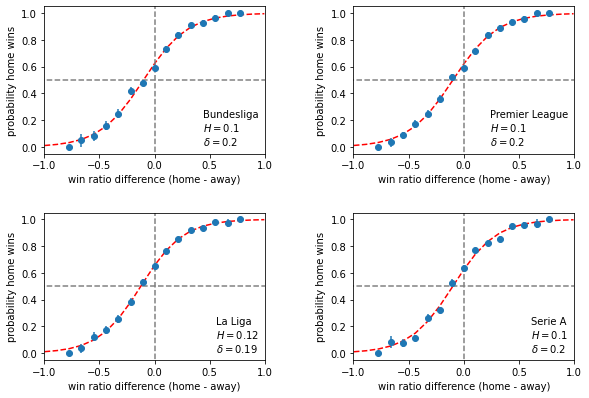

In [69]:
from scipy.optimize import minimize
from matplotlib.offsetbox import AnchoredText

NUM_BINS = 21
leagues = ["Bundesliga", "Premier League", "La Liga", "Serie A"]

# Build bins
bins = build_bins(NUM_BINS)

fig, axes = plt.subplots(2, 2, figsize=FIGSIZE)
for i, league in enumerate(leagues):
    
    all_games_with_winratios = compute_games_with_winratios(league, real_data_games, real_data_teams)
    all_games_with_winratios = all_games_with_winratios[all_games_with_winratios["draw"] == 0]  # Filter draws

    ##################
    # Empirical Part #
    ##################
    home_won_per_bin = all_games_with_winratios.groupby('win_ratio_bin').agg({'home_won':['mean','sem']}).reset_index()
    home_won_per_bin['win_ratio_bin_mid'] = home_won_per_bin['win_ratio_bin'].apply(lambda x: x.mid)
    
    ############
    # MLE Part #
    ############
    mle_X = all_games_with_winratios["delta_w"]
    mle_Y = all_games_with_winratios["home_won"]

    model = minimize(gen_data_likelihood(mle_X, mle_Y), [0.1, 3], method='Nelder-Mead')
    mle_H = round(model["x"][0] * 100) / 100
    mle_delta = round(model["x"][1] * 100) / 100
#     print(f"H: {model['x'][0]}, delta {model['x'][1]}, loss {model['fun']}")

    ############
    # Plotting #
    ############
    X = home_won_per_bin['win_ratio_bin_mid']
    ax = axes[int(i / 2), i % 2]
    ax.errorbar(X, home_won_per_bin['home_won']['mean'], yerr=home_won_per_bin['home_won']['sem'], \
                     marker='o', linestyle='')
    
    ax.plot(X, winratio_model(X.to_numpy(), model['x'][0], model['x'][1]), color='red', linestyle='dashed')
    
    ax.set_ylabel("probability home wins")
    ax.set_xlabel("win ratio difference (home - away)")
    ax.set_xlim(-1.0, 1.0)
    ax.set_ylim(-0.05, 1.05)
    
    ax.axhline(0.5, -1.1, 1.1, linestyle='dashed', color='gray')
    ax.axvline(0.0, -0.1, 1.1, linestyle='dashed', color='gray')
    
    textstr = '\n'.join((
    f'{league}',
    f'$H={mle_H}$',
    f'$\\delta={mle_delta}$'))

    # place a text box in upper left in axes coords
    text_box = AnchoredText(textstr, frameon=True, loc=4, pad=0.1)
    plt.setp(text_box.patch, facecolor='white', alpha=1.0, edgecolor='none')
    ax.add_artist(text_box)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.savefig("plots/figure1.png", bbox_inches="tight")
plt.show()

# Figure 2

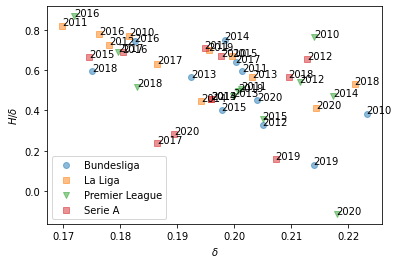

,league,start_year,H,delta
0,Bundesliga,2010,0.085889,0.223237
1,Bundesliga,2011,0.119988,0.201367
2,Bundesliga,2012,0.066782,0.204987
3,Bundesliga,2013,0.108875,0.192380
4,Bundesliga,2014,0.149042,0.198284
5,Bundesliga,2015,0.079626,0.197763
6,Bundesliga,2016,0.135970,0.182509
7,Bundesliga,2017,0.127901,0.200247
8,Bundesliga,2018,0.104189,0.175083
9,Bundesliga,2019,0.028282,0.213942


In [70]:

relevant_cols = ["team", "win_ratio", "start_year", "league"]

all_games_with_winratios = real_data_games.merge(real_data_teams[relevant_cols], left_on=['Home', 'start_year', 'league_name'], right_on=['team', 'start_year', 'league']) \
    .merge(real_data_teams[relevant_cols], left_on=['Away', 'start_year', 'league_name'], right_on=['team', 'start_year', 'league'])
all_games_with_winratios["delta_w"] = all_games_with_winratios['win_ratio_x'] - all_games_with_winratios['win_ratio_y']

# Now calculate if home won
v = all_games_with_winratios["Score"].str.split("–", expand=True)
all_games_with_winratios["home_won"] = (v[0] > v[1]).astype(int)
all_games_with_winratios = all_games_with_winratios[v[0] != v[1]]  # Filter draws

def compute_theta(x):
    mle_X = x["delta_w"]
    mle_Y = x["home_won"]

    model = minimize(gen_data_likelihood(mle_X, mle_Y), [0.1, 3], method='Nelder-Mead')
    return model["x"][0], model["x"][1]

grouped = all_games_with_winratios[["delta_w", "home_won", "league_name", "start_year"]].groupby(['league_name', 'start_year'])
models = { i: (name + compute_theta(group)) for i, (name, group) in enumerate(grouped)}
models = pd.DataFrame.from_dict(models, orient='index', columns=['league', 'start_year', 'H', 'delta'])

config_figure_2 = {
    "Bundesliga": {'marker': 'o', 'color': 'red'},
    "Premier League": {'marker': 'v', 'color': 'yellow'},
    "La Liga": {'marker': 's', 'color': 'green'},
    "Serie A": {'marker': 's', 'color': 'blue'},
}

plt.figure(figsize=[6, 4])
for i, (league, rows) in enumerate(models.groupby('league')):
    current_league_models = models
    plt.scatter(rows['delta'], rows['H'] / rows['delta'], \
               marker=config_figure_2[league]['marker'], color=plt.cm.tab10(i), \
               alpha=0.5, label=league)
    for row in rows.itertuples():
        plt.annotate(row.start_year, (row.delta, row.H / row.delta))
    
plt.xlabel("$\\delta$")
# plt.xlim(0.1, 0.35)
plt.ylabel("$H/\\delta$")
# plt.ylim(0.0, 1.5)
plt.legend()
plt.savefig("plots/figure2.png", bbox_inches="tight")
plt.show()

display(models)


### 2019 Split

<ipython-input-71-33d369d745ed>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_games_split_2019["start_year"][(real_data_games_split_2019["start_year"] == split_2019_config['start_year']) &\


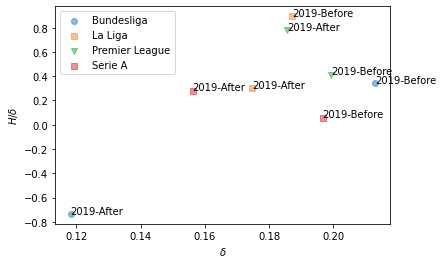

In [71]:
import datetime

split_2019_config = {
    'split_date': datetime.datetime(2020, 3, 24),
    'league': 'Bundesliga',
    'start_year': 2019
}

real_data_games_split_2019 = real_data_games.copy()
real_data_games_split_2019["Date"] = pd.to_datetime(real_data_games_split_2019["Date"], format='%d.%m.%y')

real_data_games_split_2019["start_year"][(real_data_games_split_2019["start_year"] == split_2019_config['start_year']) &\
                           (real_data_games_split_2019["Date"] >= split_2019_config['split_date'])] = "2019-After"
real_data_games_split_2019["start_year"][(real_data_games_split_2019["start_year"] == split_2019_config['start_year']) &\
                           (real_data_games_split_2019["Date"] < split_2019_config['split_date'])] = "2019-Before"
    
real_data_teams_split_2019 = build_real_data_teams(real_data_games_split_2019)

relevant_cols = ["team", "win_ratio", "start_year", "league"]

# Only show 2019
real_data_games_split_2019 = real_data_games_split_2019[(real_data_games_split_2019["start_year"] == "2019-Before") | (real_data_games_split_2019["start_year"] == "2019-After")]

all_games_with_winratios = real_data_games_split_2019.merge(real_data_teams_split_2019[relevant_cols], left_on=['Home', 'start_year', 'league_name'], right_on=['team', 'start_year', 'league']) \
    .merge(real_data_teams_split_2019[relevant_cols], left_on=['Away', 'start_year', 'league_name'], right_on=['team', 'start_year', 'league'])
all_games_with_winratios["delta_w"] = all_games_with_winratios['win_ratio_x'] - all_games_with_winratios['win_ratio_y']

# Now calculate if home won
v = all_games_with_winratios["Score"].str.split("–", expand=True)
all_games_with_winratios["home_won"] = (v[0] > v[1]).astype(int)
all_games_with_winratios = all_games_with_winratios[v[0] != v[1]]  # Filter draws

def compute_theta(x):
    mle_X = x["delta_w"]
    mle_Y = x["home_won"]

    model = minimize(gen_data_likelihood(mle_X, mle_Y), [0.1, 3], method='Nelder-Mead')
    return model["x"][0], model["x"][1]

grouped = all_games_with_winratios[["delta_w", "home_won", "league_name", "start_year"]].groupby(['league_name', 'start_year'])
models = { i: (name + compute_theta(group)) for i, (name, group) in enumerate(grouped)}
models = pd.DataFrame.from_dict(models, orient='index', columns=['league', 'start_year', 'H', 'delta'])

plt.figure()
for i, (league, rows) in enumerate(models.groupby('league')):
    current_league_models = models
    plt.scatter(rows['delta'], rows['H'] / rows['delta'], \
               marker=config_figure_2[league]['marker'], color=plt.cm.tab10(i), \
               alpha=0.5, label=league)
    for row in rows.itertuples():
        plt.annotate(row.start_year, (row.delta, row.H / row.delta))
    
plt.xlabel("$\\delta$")
# plt.xlim(0.1, 0.35)
plt.ylabel("$H/\\delta$")
# plt.ylim(0.0, 1.5)
plt.legend()
plt.show()

# Plotting

In [72]:
from scipy.optimize import least_squares

def nonlinear_fitness_model(theta, i, N):
    """
    N is fixed
    gamma is set after tweaking alpha and beta to normalize.
    """
    alpha, beta, gamma = theta[0], theta[1], theta[2]
    # print(alpha, beta)
    return beta * np.power((i - 0.5) / N, alpha) + gamma
    # return theta[0] / (1 + np.exp(- theta[1] * (t - theta[2])))
    
    
def determine_gamma(alpha, beta, N):
    """
    In case choose alfa and beta, we should be normalize the winratios so that the average is always 0.5 (someones win
    is always someone elses loss).
    This should be implicit in the natural data that we get.
    :return: gamma
    """
    average = np.sum([nonlinear_fitness_model([alpha, beta], i, N) for i in range(1, N+1)]) / N
    return 0.5 - average


def fit_nonlinear_model(df, visualize=False):

    # Prepare datapoints
    N = df['rank'].count()
    X = df['rank'].values
    Y = df['win_ratio'].values
    def fun(theta):
        return nonlinear_fitness_model(theta, X, N) - Y

    theta0 = [0.5,2, 0]
    result = least_squares(fun, theta0)
    result_theta = result.x

    if visualize:
        plt.scatter(X, Y, color="red")
        plt.plot(X, [nonlinear_fitness_model(result_theta, t, N) for t in X])
        for label, (x, y) in zip(df['team'].values, zip(X, Y)):
            plt.annotate(label, (x, y))
        print(f"Average winratio input: {np.sum(Y) / N}")
        print(f"Average winratio: {np.sum([nonlinear_fitness_model(result_theta, t, N) for t in X]) / N}")

    if visualize:
        print(np.sum([nonlinear_fitness_model(result_theta, t, N) for t in X]) / N)
        plt.plot(X, [nonlinear_fitness_model(result_theta, t, N) for t in X], color='green')

        print(f"alpha={result_theta[0]}, beta={result_theta[1]}, gamma={result_theta[2]}")

    return result_theta[0], result_theta[1], result_theta[2]

Premier League (2010-2011)
Average winratio input: 0.4987532485382028
Average winratio: 0.49875324854706066
0.49875324854706066
alpha=2.0931981872778724, beta=0.49343621876913063, gamma=0.3393379403912956


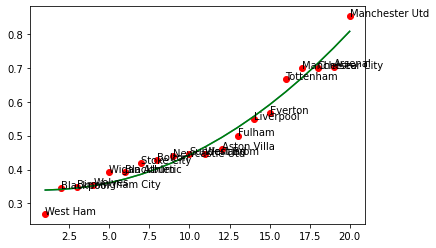

In [73]:
print("Premier League (2010-2011)")
data_premier_league_2010 = real_data_teams[(real_data_teams["league"] == "Premier League") & (real_data_teams["start_year"] == 2010)]
_, _, _ = fit_nonlinear_model(data_premier_league_2010, visualize=True)

In [74]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
# General plotting config

COLOR_GRAY = '#666666'

plot_config = {
    'colors': {
        0.1: 'red',
        0.3: 'green',
        0.8: 'blue',

        # Smaller data
        0.5: 'red',
        1.0: 'green',
        
        # algos
        "winratio": 'green',
        "pagerank": 'red',
        "bipagerank": 'blue',
        "hits": 'black',
        "bihits": 'grey'
    },
    'linestyles': {
        "pagerank": "dashed",
        "bipagerank": "dotted",
        "winratio": "solid",
        "hits": "dashdot",
        "bihits": (0, (3, 10, 1, 10, 1, 10))
    },
    'algo_names': {
        "pagerank": "PageRank",
        "bipagerank": "BiPageRank",
        "winratio": "WinRatio",
        "hits": "Hits",
        "bihits": "BiHits"
    },
    'ylabels': {
        "top5_avg_rank": "average ranking of top 5",
        "kendall": "Kendall $\\tau$",
        "auc": "AUC of top 5"
    },
    "update_removal_mode_names":{
        "removal": "upset removal",
        "reversion": "upset reversion"
    }
}

In [75]:
# configure here the experiments (the pipeline will create a cross product for every element in a list)
config = {
    "n_teams": [30],
    "fitness": [{"type": "linear"}],
    "model": [{"type": "logistic", "H": [0], "delta": np.linspace(0.01, 0.4, 26) }],
    "fraction_games_per_season": np.concatenate([np.linspace(0.04, 1.0, 10), [0.1, 0.3, 0.8]]), # P in paper (can only be between [0,1])
    "remove_unexpected": [{"mode": ["removal"], "fraction_eta": [0.0]}],
    "n_seasons": 100, # number of repetitions
    "ranking_algos": ["pagerank", "bipagerank", "winratio"],
    "metrics": ["kendall", "auc", "top5_avg_rank"],
    "fix_schedule_over_season": False,
    "schedule": "roundrobin" # "graph" # "roundrobin"
}

df_fig3 = build_df(config)
#display(drop_additional_cols(df_fig3))

Config results in 33800 experiments
Using config from disk (config_1304353656340532453.json)


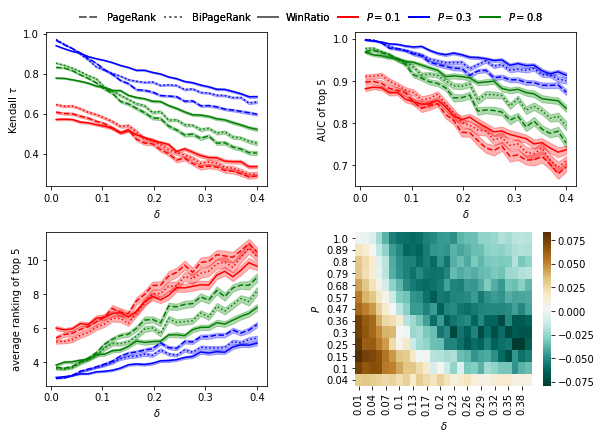

In [76]:

plot_fractions = [0.1, 0.3, 0.8]

def build_figure_3(df, use_heatmap=True):
    plots_v = 2
    plots_h = 2
    fig, axes = plt.subplots(plots_v, plots_h, figsize=FIGSIZE)
    fig.subplots_adjust(wspace=0.4, hspace=0.3)

    #######################
    # First three figures #
    #######################
    for index, metric in enumerate(config['metrics']):
        for algo in config['ranking_algos']:
            for fraction in plot_fractions:
                rows = df[np.isclose(df[f"fraction_games_per_season"], fraction)]
                groups = rows.groupby("model_logistic_delta")
                labels = groups.groups.keys()

                suffix = f"{algo}_{metric}"
                values = groups.mean()[suffix]
                stderr = groups.sem()[suffix]
                ax = axes[int(index / plots_h), index % plots_h]
                ax.plot(labels, values,
                                color=plot_config['colors'][fraction],
                                linestyle=plot_config['linestyles'][algo]
                                )
                ax.fill_between(labels, values - stderr, values + stderr,
                                        color=plot_config['colors'][fraction],
                                        alpha=0.3)

                ax.set_ylabel(plot_config['ylabels'][metric])
                ax.set_xlabel("$\delta$")

    #######################
    # Heatmap #
    #######################
    if use_heatmap:
        plot_data = df
        plot_data["difference"] = plot_data["bipagerank_kendall"] - plot_data["winratio_kendall"]
        plot_data = plot_data[["model_logistic_delta", "fraction_games_per_season", "difference"]]
        grouped = plot_data.round({"model_logistic_delta": 2, "fraction_games_per_season": 2})\
                        .groupby(["model_logistic_delta", "fraction_games_per_season"]).mean()
        grouped = grouped["difference"].unstack(0)

#         yticklabels = np.round(np.sort(config["fraction_games_per_season"]), 2)
#         yticklabels[::2] = None
        
#         xticklabels = np.round(np.sort(config["model"][0]["delta"]), 2)
#         xticklabels[::2] = None
        
        ax = sns.heatmap(grouped, cmap="BrBG_r", ax=axes[1, 1])
        ax.invert_yaxis()
        ax.set_ylabel("$P$")

        ax.set_xlabel("$\\delta$")

    ##########
    # LEGEND #
    ##########

    legend_algo = [Line2D([0], [0], linestyle=plot_config['linestyles'][algo], lw=2, color=COLOR_GRAY) for algo in config['ranking_algos']]
    legend_fraction = [Line2D([0], [0], linestyle='solid', lw=2, color=plot_config['colors'][algo]) for algo in config['ranking_algos']]

    total_legend = [plot_config['algo_names'][key] for key in config['ranking_algos']] + [f"$P = {fraction}$" for fraction in plot_fractions] 
    
    leg = plt.legend(legend_algo + legend_fraction, total_legend,
                      bbox_to_anchor=(-0.25, 2.5), loc='upper center',
                      ncol=len(plot_config['colors'].keys()), columnspacing=0.75, framealpha=0.0)
    fig.add_artist(leg)
    plt.savefig("plots/figure3.png", bbox_inches="tight")
    plt.show()

build_figure_3(df_fig3, use_heatmap=True)


In [77]:
# configure here the experiments (the pipeline will create a cross product for every element in a list)
config = {
    "n_teams": [30],
    "fitness": [{"type": "linear"}],
    "model": [{"type": "logistic", "H": np.linspace(0.0, 0.3, 26), "delta": [0.1]}],
    "fraction_games_per_season": [0.1, 0.3, 0.8], # P in paper (can only be between [0,1])
    "remove_unexpected": [{"mode": ["removal"], "fraction_eta": [0.0]}],
    "n_seasons": 50, # number of repetitions
    "ranking_algos": ["pagerank", "bipagerank", "winratio"],
    "metrics": ["top5_avg_rank", "kendall", "auc"],
    "fix_schedule_over_season": False,
    "schedule": "roundrobin" #"graph" 
}

df_fig4 = build_df(config)
#display(drop_additional_cols(df_fig4))

Config results in 3900 experiments
Using config from disk (config_5652302980855631377.json)


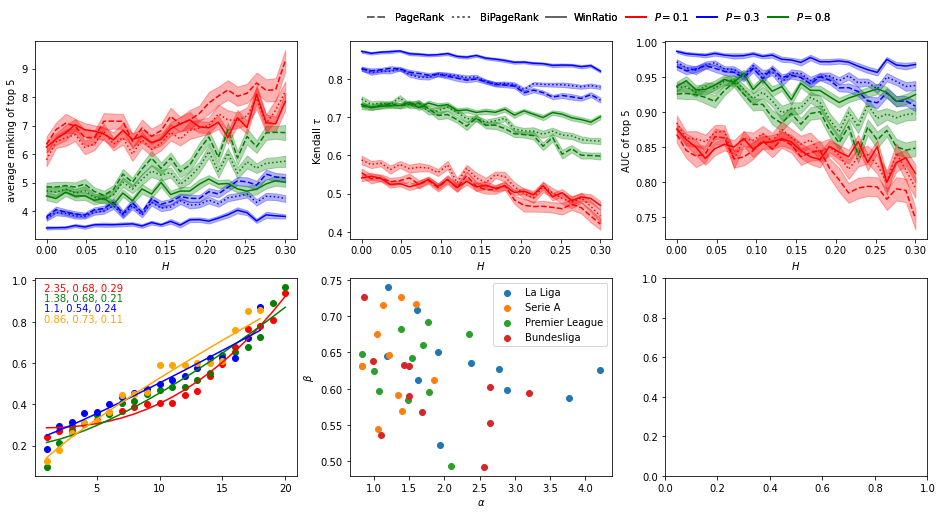

In [92]:

leagues_to_fit = [
    {'league': 'Premier League', 'start_year': 2017, 'color': 'red'},
    {'league': 'Premier League', 'start_year': 2018, 'color': 'green'},
#     {'league': 'Premier League', 'start_year': 2019, 'color': 'blue'},
#     {'league': 'Premier League', 'start_year': 2020, 'color': 'orange'}


    {'league': 'Bundesliga', 'start_year': 2017, 'color': 'blue'},
    {'league': 'Bundesliga', 'start_year': 2018, 'color': 'orange'}


]
plot_fractions = [0.1, 0.3, 0.8]
    

def build_figure_4(df, use_part2=True):
    plots_v = 2 #if use_part2 else 1
    plots_h = 3
    fig, axes = plt.subplots(plots_v, plots_h, figsize=[16, 8])
    fig.subplots_adjust(wspace=0.2, hspace=0.2)

    #######################
    # First three figures #
    #######################
    for index, metric in enumerate(config['metrics']):
        for algo in config['ranking_algos']:
            for fraction in config['fraction_games_per_season']:
                rows = df[np.isclose(df[f"fraction_games_per_season"], fraction)]
#                 print(fraction, rows)
                groups = rows.groupby("model_logistic_H")
                labels = groups.groups.keys()

                suffix = f"{algo}_{metric}"
                values = groups.mean()[suffix]
                stderr = groups.sem()[suffix]
                #if use_part2:
                ax = axes[int(index / plots_h), index % plots_h]
                #else:
                #    ax = axes[index % plots_h]
                ax.plot(labels, values,
                                color=plot_config['colors'][fraction],
                                linestyle=plot_config['linestyles'][algo]
                                )
                ax.fill_between(labels, values - stderr, values + stderr,
                                        color=plot_config['colors'][fraction],
                                        alpha=0.3)

                ax.set_ylabel(plot_config['ylabels'][metric])
                ax.set_xlabel("$H$")

    if use_part2:
        ##########################
        # Fitting fitness values #
        ##########################
        ax = axes[1, 0]
        for i, league in enumerate(leagues_to_fit):
            row = real_data_teams[(real_data_teams['league'] == league['league']) &\
                                  (real_data_teams['start_year'] == league['start_year'])]
            N = row['rank'].count()
            color = league['color']
            ax.scatter(row['rank'], row['win_ratio'], color=color)

            alpha, beta, gamma = fit_nonlinear_model(row)
            ax.text(0.8, 0.95 - (i * 0.05), f"{round(alpha, 2)}, {round(beta, 2)}, {round(gamma, 2)}", color=color)
            ax.plot(row['rank'], [nonlinear_fitness_model([alpha, beta, gamma], i, N) for i in range(1, N+1)], color=color)

        ##########################
        # Plotting alfa, beta #
        ##########################
    #     print(list(real_data_teams.iteritems()))
    #     print(list(real_data_teams.iteritems())[0])

        ax = axes[1, 1]
        for _, (league) in real_data_teams["league"].drop_duplicates().iteritems():
            fits = []

            for _, (start_year, end_year) in real_data_teams[["start_year", "end_year"]]\
                                                    .drop_duplicates().iterrows():
                season = real_data_teams[(real_data_teams["start_year"] == start_year) &\
                                         (real_data_teams["end_year"] == end_year) &\
                                         (real_data_teams["league"] == league)]
                alpha, beta, gamma = fit_nonlinear_model(season)
                fits.append((alpha, beta))

            ax.scatter([f[0] for f in fits], [f[1] for f in fits], label=f"{league}")
        ax.set_xlabel("$\\alpha$")
        ax.set_ylabel("$\\beta$")
        ax.legend()


    #######################
    # Heatmap #
    #######################
    # TODO Based on real data
#     plot_data = df
#     ax = 
#     plot_data["difference"] = plot_data["bipagerank_kendall"] - plot_data["winratio_kendall"]
#     plot_data = plot_data[["model_logistic_delta", "fraction_games_per_season", "difference"]]
#     grouped = plot_data.groupby(["model_logistic_delta", "fraction_games_per_season"]).mean()
#     grouped = grouped["difference"].unstack(0)
    
#     ax = sns.heatmap(grouped, cmap="BrBG", ax=axes[1, 1])
#     ax.set_ylabel("$P$")
#     ax.set_xlabel("$H$")
#     ax.set_xticks([0.01, 0.08, 0.16, 0.24, 0.4])

    ##########
    # LEGEND #
    ##########

    legend_algo = [Line2D([0], [0], linestyle=plot_config['linestyles'][algo], lw=2, color=COLOR_GRAY) for algo in config['ranking_algos']]
    legend_fraction = [Line2D([0], [0], linestyle='solid', lw=2, color=plot_config['colors'][algo]) for algo in config['ranking_algos']]

    total_legend = [plot_config['algo_names'][key] for key in config['ranking_algos']] + [f"$P = {fraction}$" for fraction in plot_fractions] 
    
    leg = plt.legend(legend_algo + legend_fraction, total_legend,
                      bbox_to_anchor=(-0.25, 2.4), loc='upper center',
                      ncol=len(plot_config['colors'].keys()), columnspacing=0.75, framealpha=0.0)
    fig.add_artist(leg)
    plt.show()

build_figure_4(df=df_fig4, use_part2=True)


### Figure 5

In [79]:
# configure here the experiments (the pipeline will create a cross product for every element in a list)
config_fig5 = {
    "n_teams": [30],
    "fitness": [{"type": "nonlinear", "alpha": [1.5], "beta":[0.5], "gamma": ["fix"] }],
    "model": [{"type": "logistic", "H": [0.08], "delta": [0.25] }],
    "fraction_games_per_season":  [1], # P in paper (can only be between [0,1])
    "remove_unexpected": [{"mode": ["removal", "reversion"], "fraction_eta": np.linspace(0, 1, 50)}], 
    "n_seasons": 30, # number of repetitions
    "ranking_algos": ["pagerank", "bipagerank", "winratio"],
    "metrics": ["kendall"],
    "fix_schedule_over_season": True,
    "schedule": "roundrobin" # "graph" # "roundrobin"
}

df_fig5 = build_df(config_fig5)
#display(drop_additional_cols(df_fig5))

Config results in 3000 experiments


  0%|          | 0/3000 [00:00<?, ?it/s]

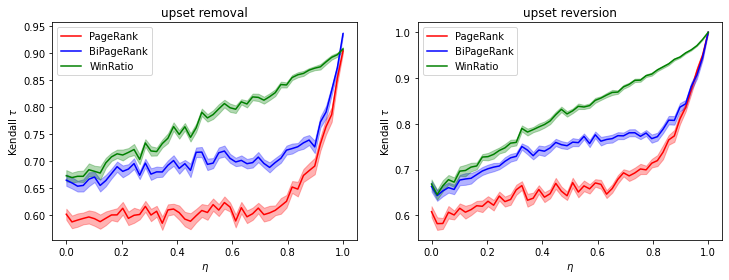

In [80]:
def build_figure_5(df, config):
    plots_v = 1
    plots_h = 2
    fig, axes = plt.subplots(plots_v, plots_h, figsize=[12, 4])
    fig.subplots_adjust(wspace=0.2, hspace=0.2)
    
    metric = "kendall"
    for index, remove_unexpected_mode in enumerate(df['remove_unexpected_mode'].unique()):
        for algo in config['ranking_algos']:
            rows = df[df["remove_unexpected_mode"]==remove_unexpected_mode]
            groups = rows.groupby("remove_unexpected_fraction_eta")
            labels = groups.groups.keys()

            suffix = f"{algo}_{metric}"
            values = groups.mean()[suffix]
            stderr = groups.sem()[suffix]
            ax = axes[index]
            ax.plot(labels, values,
                            label=plot_config["algo_names"][algo],
                            color=plot_config['colors'][algo])
            ax.fill_between(labels, values - stderr, values + stderr,
                                    color=plot_config['colors'][algo],
                                    alpha=0.3)

            ax.set_ylabel(plot_config['ylabels'][metric])
            ax.set_xlabel("$\\eta$")
            ax.set_title(plot_config["update_removal_mode_names"][remove_unexpected_mode])
            ax.legend()
    plt.show()

build_figure_5(df_fig5, config_fig5)

## Visualize a Graph

In [81]:
# Show winner graph of 1st experiment
#exp = df.iloc[0]
        
#G = games_to_graph(n_teams=exp["n_teams"], games=exp["results"], graph="winner")

#pos=nx.spring_layout(G)
#nx.draw(G, pos)
#labels = nx.get_edge_attributes(G,'weight')
#nx.draw_networkx_edge_labels(G,pos, edge_labels=labels)
#labels= {i: node for i, node in enumerate(range(exp["n_teams"]))}
#nx.draw_networkx_labels(G,pos,labels=labels,font_size=16)

# Extensions

## Draws

### Model for draws
Model explanation, extend binary probability to three probabilities with softmax

In [82]:
import numpy as np

def softmax(vec):
    ex = np.exp(vec)
#     print(np.sum(ex, axis=1))
    return ex / np.sum(ex, axis=0)

def our_model_win(delta_w, H, delta):
    return (delta_w + H) / delta

def our_model_lose(delta_w, H, delta):
    return -(delta_w + H) / delta

def our_model_draw(delta_w, H):
    return -((delta_w + H) * (delta_w + H))

def our_model_with_draws(delta_w, H, delta):
    P_win = our_model_win(delta_w, H, delta)
    P_lose = our_model_lose(delta_w, H, delta)
    P_draw = our_model_draw(delta_w, H)
    P_vec = np.array([P_win, P_lose, P_draw])
    P_vec = softmax(P_vec)
    return P_vec

def gen_data_likelihood_with_draws(X, Y):
    def data_likelihood(theta):
        # X: empirical winratio difference
        # Y: Game results, vector
        H, delta = theta[0], theta[1]
        P_vec = our_model_with_draws(X, H, delta)
        return -np.sum(np.multiply(Y, np.log(P_vec.T)))
    
    return data_likelihood

H: 0.09408788569634498, delta 0.38570719456675095, loss 0.9566302937613937
H: 0.09834389694539217, delta 0.38348285982973407, loss 0.9405467885750534
H: 0.1246008150372491, delta 0.37152125061351193, loss 0.9272733977606018
H: 0.09576074333963863, delta 0.3927199524391889, loss 0.9448967931147182


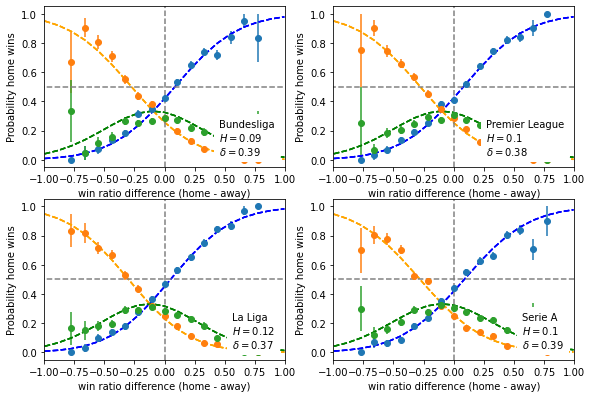

In [83]:
from scipy.optimize import minimize
from matplotlib.offsetbox import AnchoredText

NUM_BINS = 21
leagues = ["Bundesliga", "Premier League", "La Liga", "Serie A"]
stats = ['home_won', 'away_won', 'draw']

# Build bins
bins = build_bins(NUM_BINS)

def round_params(p):
    return round(p * 100) / 100

fig, axes = plt.subplots(2, 2, figsize=FIGSIZE)
for i, league in enumerate(leagues):
    
    all_games_with_winratios = compute_games_with_winratios(league, real_data_games, real_data_teams)
    
    ############
    # MLE Part #
    ############
    mle_X = np.array(all_games_with_winratios["delta_w"])
    mle_Y = np.array(all_games_with_winratios[stats])

    model = minimize(gen_data_likelihood_with_draws(mle_X, mle_Y), [0.1, 0.1], method='Nelder-Mead')
    mle_H, mle_delta = model["x"][0], model["x"][1]
    
    print(f"H: {model['x'][0]}, delta {model['x'][1]}, loss {model['fun'] / mle_X.shape[0]}")
    
    for stat in stats:
    
        ##################
        # Empirical Part #
        ##################
        home_won_per_bin = all_games_with_winratios.groupby('win_ratio_bin').agg({stat:['mean','sem', 'count']}).reset_index()
        home_won_per_bin['win_ratio_bin_mid'] = home_won_per_bin['win_ratio_bin'].apply(lambda x: x.mid)

        ############
        # Plotting #
        ############
        X = home_won_per_bin['win_ratio_bin_mid']
        ax = axes[int(i / 2), i % 2]
        ax.errorbar(X, home_won_per_bin[stat]['mean'], yerr=home_won_per_bin[stat]['sem'], \
                         marker='o', linestyle='', label=stat)
        
        sm = our_model_with_draws(X.to_numpy(), mle_H, mle_delta)
        ax.plot(X, sm[0], color='blue', linestyle='dashed')
        ax.plot(X, sm[1], color='orange', linestyle='dashed')
        ax.plot(X, sm[2], color='green', linestyle='dashed')
    
    ax.set_ylabel("Probability home wins")
    ax.set_xlabel("win ratio difference (home - away)")
    ax.set_xlim(-1.0, 1.0)
    ax.set_ylim(-0.05, 1.05)
    
    ax.axhline(0.5, -1.1, 1.1, linestyle='dashed', color='gray')
    ax.axvline(0.0, -0.1, 1.1, linestyle='dashed', color='gray')
        
    textstr = '\n'.join((
    f'{league}',
    f'$H={round_params(mle_H)}$',
    f'$\\delta={round_params(mle_delta)}$'))

    # place a text box in upper left in axes coords
    text_box = AnchoredText(textstr, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=1.0, edgecolor='none')
    ax.add_artist(text_box)

plt.show()

### Results with Draws

In [88]:
# configure here the experiments (the pipeline will create a cross product for every element in a list)
config = {
    "n_teams": [30],
    "fitness": [{"type": "linear"}],
    "model": [{"type": "softmax", "H": [0], "delta": np.linspace(0.01, 0.5, 10) }],
    "fraction_games_per_season": np.concatenate([np.linspace(0.04, 1.0, 4), [0.1, 0.3, 0.8]]), # P in paper (can only be between [0,1])
    "remove_unexpected": [{"mode": ["removal"], "fraction_eta": [0.0]}],
    "n_seasons": 50, # number of repetitions
    "ranking_algos": ["pagerank", "bipagerank", "winratio"],
    "metrics": ["top5_avg_rank", "kendall", "auc"],
    "fix_schedule_over_season": False,
    "schedule": "roundrobin" # "graph" # "roundrobin"
}

df_fig3_with_draws = build_df(config)
#display(drop_additional_cols(df_fig3_with_draws))

Config results in 3500 experiments


  0%|          | 0/3500 [00:00<?, ?it/s]

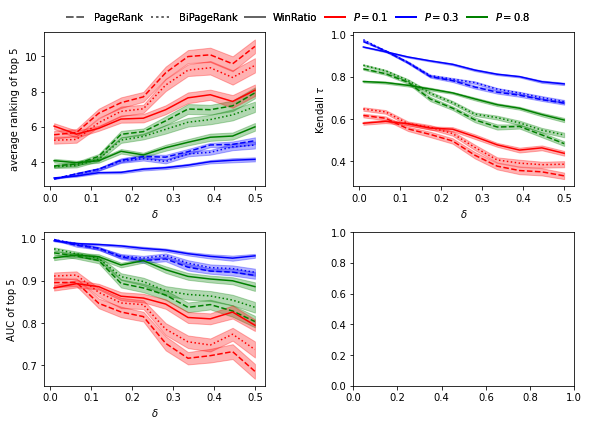

In [89]:
build_figure_3(df=df_fig3_with_draws, use_heatmap=False)

In [90]:
# configure here the experiments (the pipeline will create a cross product for every element in a list)
config = {
    "n_teams": [30],
    "fitness": [{"type": "linear"}],
    "model": [{"type": "softmax", "H": np.linspace(0.0, 0.3, 10), "delta": [0.1]}],
    "fraction_games_per_season": [0.1, 0.3, 0.8], # P in paper (can only be between [0,1])
    "remove_unexpected": [{"mode": ["removal"], "fraction_eta": [0.0]}],
    "n_seasons": 50, # number of repetitions
    "ranking_algos": ["pagerank", "bipagerank", "winratio"],
    "metrics": ["top5_avg_rank", "kendall", "auc"],
    "fix_schedule_over_season": False,
    "schedule": "roundrobin" #"graph" 
}

df_fig4_with_draws = build_df(config)
#display(drop_additional_cols(df_fig4_with_draws))

Config results in 1500 experiments


  0%|          | 0/1500 [00:00<?, ?it/s]

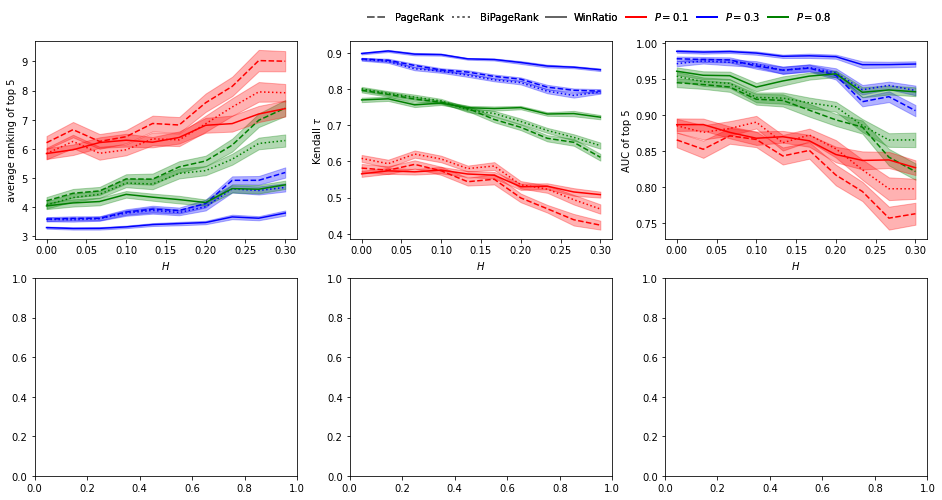

In [93]:
build_figure_4(df=df_fig4_with_draws, use_part2=False)

# HITS and BiHITS Ranking Algorithm

**Wikipedia**: Hyperlink-Induced Topic Search (HITS; also known as hubs and authorities) is a link analysis algorithm that rates Web pages, developed by Jon Kleinberg. The idea behind Hubs and Authorities stemmed from a particular insight into the creation of web pages when the Internet was originally forming; that is, certain web pages, known as hubs, served as large directories that were not actually authoritative in the information that they held, but were used as compilations of a broad catalog of information that led users direct to other authoritative pages. In other words, a good hub represents a page that pointed to many other pages, while a good authority represents a page that is linked by many different hubs.

The scheme therefore assigns two scores for each page: its authority, which estimates the value of the content of the page, and its hub value, which estimates the value of its links to other pages.

**We use the authority score for the rankings.**

In [94]:
# configure here the experiments (the pipeline will create a cross product for every element in a list)
config = {
    "n_teams": [30],
    "fitness": [{"type": "linear"}],
    "model": [{"type": "logistic", "H": [0], "delta": np.linspace(0.01, 0.4, 4) }],
    "fraction_games_per_season": np.concatenate([np.linspace(0.04, 1.0, 4), [0.1, 0.3, 0.8]]), # P in paper (can only be between [0,1])
    "remove_unexpected": [{"mode": ["removal"], "fraction_eta": [0.0]}],
    "n_seasons": 50, # number of repetitions
    "ranking_algos": ["pagerank", "bipagerank", "winratio", "hits", "bihits"],
    "metrics": ["top5_avg_rank", "kendall", "auc"],
    "fix_schedule_over_season": False,
    "schedule": "roundrobin" # "graph" # "roundrobin"
}

df_fig3_ext = build_df(config)
#display(drop_additional_cols(df_fig3_ext ))

Config results in 1400 experiments


  0%|          | 0/1400 [00:00<?, ?it/s]

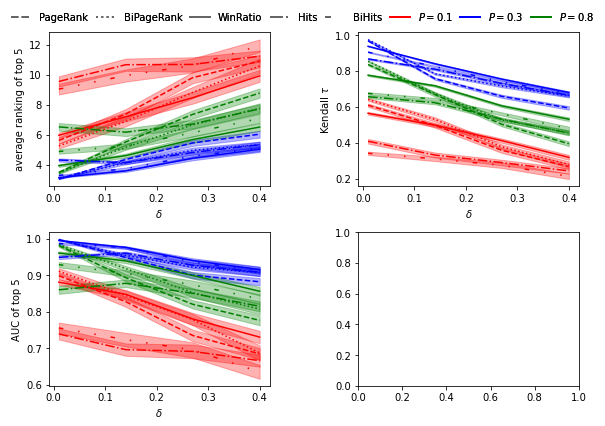

In [95]:
build_figure_3(df=df_fig3_ext, use_heatmap=False)

In [96]:
# configure here the experiments (the pipeline will create a cross product for every element in a list)
config = {
    "n_teams": [30],
    "fitness": [{"type": "linear"}],
    "model": [{"type": "logistic", "H": np.linspace(0.0, 0.3, 10), "delta": [0.1]}],
    "fraction_games_per_season": [0.1, 0.3, 0.8], # P in paper (can only be between [0,1])
    "remove_unexpected": [{"mode": ["removal"], "fraction_eta": [0.0]}],
    "n_seasons": 50, # number of repetitions
    "ranking_algos": ["pagerank", "bipagerank", "winratio", "hits", "bihits"],
    "metrics": ["top5_avg_rank", "kendall", "auc"],
    "fix_schedule_over_season": False,
    "schedule": "roundrobin" #"graph" 
}

df_fig4_ext = build_df(config)
#display(drop_additional_cols(df_fig4_ext))

Config results in 1500 experiments


  0%|          | 0/1500 [00:00<?, ?it/s]

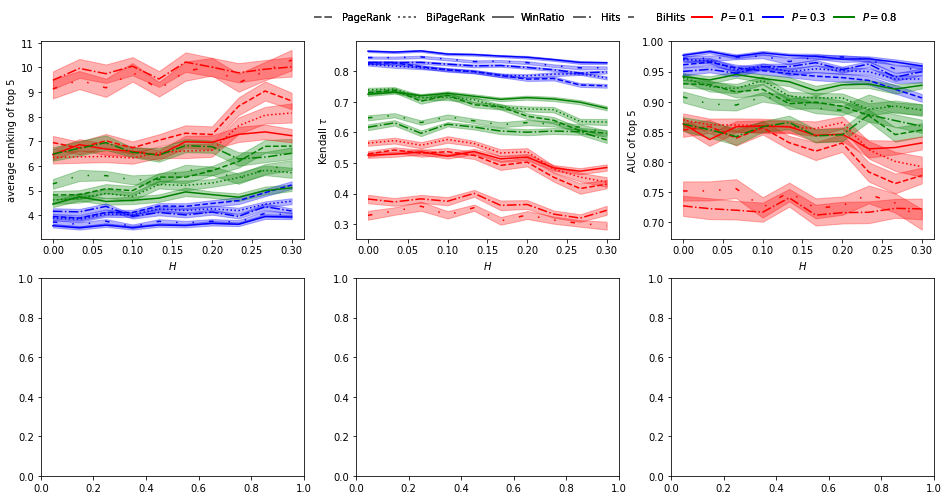

In [97]:
build_figure_4(df=df_fig4_ext, use_part2=False)

## Euro 2021

In [25]:
df = pd.read_csv("data/euro2021-schedule.csv")

# according to transfermarkt.com
fifa_ranking = {
    'Turkey': 32,
    'Wales': 18,
    'Denmark': 12,
    'Belgium': 1,
    'England': 4,
    'Austria': 23,
    'Netherlands': 14,
    'Scotland': 48,
    'Poland': 19,
    'Spain': 6,
    'Hungary': 40,
    'France': 2,
    'Finland': 55,
    'Italy': 10,
    'Ukraine': 24,
    'Sweden': 20,
    'Croatia': 11,
    'Portugal': 5,
    'Switzerland': 16,
    'North Macedonia': 65,
    'Russia': 39,
    'Czech Republic': 42,
    'Slovakia': 34,
    'Germany': 13
}



# according to transfermarkt.com
team_value = {
    'Turkey': 295,
    'Wales': 125,
    'Denmark': 300,
    'Belgium': 721,
    'England': 1010,
    'Austria': 303,
    'Netherlands': 514,
    'Scotland': 249,
    'Poland': 272,
    'Spain': 855,
    'Hungary': 86,
    'France': 1060,
    'Finland': 29,
    'Italy': 812,
    'Ukraine': 199,
    'Sweden': 202,
    'Croatia': 350,
    'Portugal': 769,
    'Switzerland': 263,
    'North Macedonia': 61,
    'Russia': 200,
    'Czech Republic': 160,
    'Slovakia': 123,
    'Germany': 942
}

fitness = linear_fitness(len(fifa_ranking))
fitness_values = {team[0]: fitness[pos] for pos, team in enumerate(sorted(fifa_ranking.items(), key=lambda x: -x[1]))}


def simulate_euros(df, fitness_values):

    # Schedule According to this:
    # https://www.fussball-wm.pro/wp-content/uploads/sites/1/2021/04/spielplan-em-2021.pdf

    groups = {}
    for _, row in  df.iterrows():

        if pd.isna(row["Group"]):
            break

        if row["Group"] not in groups:
            groups[row["Group"]] = {}

        groups[row["Group"]][row["Home Team"]] = 0
        groups[row["Group"]][row["Away Team"]] = 0

    #display(groups)

    def simulate_game(home, away):
        f_i = fitness_values[home]
        f_j = fitness_values[away]
        H = 0
        delta = 0.23 # TODO need to train this
        prob = logistic_model(f_i, f_j, H, delta)
        winner = choices(["home", "away"], [prob, 1-prob])[0]

        if winner == "home":
            return home
        else:
            return away


    for _, row in  df.iterrows():
        if pd.isna(row["Group"]):
            break

        winner = simulate_game(row["Home Team"], row["Away Team"])

        # assign the winner a point
        groups[row["Group"]][winner] += 1
    
    results = {}
    
    results["Group Stage"] = groups

    d = {}

    for group_name, group in groups.items():
        gid = group_name.split()[1]

        lst = [x for x in group.items()]

        random.shuffle(lst)
        # TODO should take the direct game into account

        table = [x for x in sorted(lst, key=lambda x: -x[1])]

        d[f"1{gid}"] = table[0]
        d[f"2{gid}"] = table[1]
        d[f"3{gid}"] = table[2]


    # find the four best teams that are placed 3rd
    lst = [(d["3A"], "A") ,(d["3B"], "B") ,(d["3C"], "C"), (d["3D"], "D"), (d["3E"], "E"), (d["3F"], "F")]
    random.shuffle(lst)
    table_3rd = [x for x in sorted(lst, key=lambda x: -x[0][1])]




    c = {y: x for x, y in table_3rd[0:4]}

    base_choices = set([x for x in c.keys()])

    res = None
    for g1 in base_choices & set(["D", "E", "F"]):
        for g2 in base_choices & set(["A", "E", "F"]):
            for g3 in base_choices & set(["A", "B", "C"]):
                for g4 in base_choices & set(["A", "B", "C", "D"]):
                    if len(set([g1,g2,g3,g4])) == 4:
                        res = (g1, g2, g3, g4)
                        break



    round_of_16 = [
        (d["2A"][0],d["2B"][0]), # 1
        (d["1A"][0],d["2C"][0]), # 2
        (d["1C"][0],d[f"3{res[0]}"][0]), # 3
        (d["1B"][0],d[f"3{res[1]}"][0]), # 4
        (d["2D"][0],d["2E"][0]),  # 5
        (d["1F"][0],d[f"3{res[2]}"][0]), # 6
        (d["1D"][0],d["2F"][0]), # 7
        (d["1F"][0],d[f"3{res[3]}"][0]), # 8
    ]
    
    
    winners_r16 = []
    for game in round_of_16:
        winner = simulate_game(game[0], game[1])
        winners_r16.append(winner)
    
    results["r16"] = round_of_16
    results["r16_winner"] = winners_r16

    round_of_8 = [ # quarter final
        (winners_r16[4], winners_r16[5]),
        (winners_r16[1], winners_r16[3]),
        (winners_r16[0], winners_r16[2]),
        (winners_r16[6], winners_r16[7])
    ]

    winners_r8 = []
    for game in round_of_8:
        winner = simulate_game(game[0], game[1])
        winners_r8.append(winner)

    results["r8"] = round_of_8
    results["r8_winner"] = winners_r8


    round_of_4 = [ #semi final
        (winners_r8[1], winners_r8[0]),
        (winners_r8[3], winners_r8[2]),
    ]

    winners_r4 = []
    for game in round_of_4:
        winner = simulate_game(game[0], game[1])
        winners_r4.append(winner)
    results["r4"] = round_of_4
    results["r4_winner"] = winners_r4


    final = (winners_r4[0], winners_r4[1])
    winner_final = simulate_game(final[0], final[1])
    
    results["final"] = [final]
    results["final_winner"] = [winner_final]
    
    return winner_final, results


def print_round(games, winners):
    for game, winner in zip(games, winners):
        print(f"{game} -> {winner}")

def print_results(results):
    print("After Group Stage:")
    display(results["Group Stage"])
    
    print("\n\nRound of 16:")
    print_round(results["r16"], results["r16_winner"])
    
    print("\n\nRound of 8:")
    print_round(results["r8"], results["r8_winner"])
    
    print("\n\nRound of 4:")
    print_round(results["r4"], results["r4_winner"])
    
    print("\n\nFinal:")
    print_round(results["final"], results["final_winner"])


In [23]:
winner = None
count = 0
while winner != "Netherlands":
    winner, results = simulate_euros(df, fitness_values)
    count += 1
print(f"How often do we have to repeat the EURO 2021 until Netherlands wins: {count}")
print("==============================================================================")
print_results(results)

How often do we have to repeat the EURO 2021 until Netherlands wins: 52
After Group Stage:


{'Group A': {'Turkey': 0, 'Italy': 3, 'Wales': 1, 'Switzerland': 2},
 'Group B': {'Denmark': 2, 'Finland': 1, 'Belgium': 3, 'Russia': 0},
 'Group D': {'England': 3, 'Croatia': 2, 'Scotland': 0, 'Czech Republic': 1},
 'Group C': {'Austria': 1,
  'North Macedonia': 1,
  'Netherlands': 1,
  'Ukraine': 3},
 'Group E': {'Poland': 1, 'Slovakia': 0, 'Spain': 2, 'Sweden': 3},
 'Group F': {'Hungary': 0, 'Portugal': 1, 'France': 3, 'Germany': 2}}



Round of 16:
('Switzerland', 'Denmark') -> Denmark
('Italy', 'Netherlands') -> Netherlands
('Ukraine', 'Poland') -> Ukraine
('Belgium', 'Portugal') -> Belgium
('Croatia', 'Spain') -> Spain
('France', 'Finland') -> France
('England', 'Germany') -> Germany
('France', 'Wales') -> France


Round of 8:
('Spain', 'France') -> France
('Netherlands', 'Belgium') -> Netherlands
('Denmark', 'Ukraine') -> Denmark
('Germany', 'France') -> France


Round of 4:
('Netherlands', 'France') -> Netherlands
('France', 'Denmark') -> France


Final:
('Netherlands', 'France') -> Netherlands


In [24]:
winner = None
count = 0
while winner != "Switzerland":
    winner, results = simulate_euros(df, fitness_values)
    count += 1
print(f"How often do we have to repeat the EURO 2021 until Switzerland wins: {count}")
print("==============================================================================")
print_results(results)

How often do we have to repeat the EURO 2021 until Switzerland wins: 54
After Group Stage:


{'Group A': {'Turkey': 1, 'Italy': 1, 'Wales': 2, 'Switzerland': 2},
 'Group B': {'Denmark': 3, 'Finland': 0, 'Belgium': 2, 'Russia': 1},
 'Group D': {'England': 3, 'Croatia': 2, 'Scotland': 0, 'Czech Republic': 1},
 'Group C': {'Austria': 2,
  'North Macedonia': 0,
  'Netherlands': 3,
  'Ukraine': 1},
 'Group E': {'Poland': 2, 'Slovakia': 0, 'Spain': 1, 'Sweden': 3},
 'Group F': {'Hungary': 0, 'Portugal': 2, 'France': 3, 'Germany': 1}}



Round of 16:
('Wales', 'Belgium') -> Belgium
('Switzerland', 'Austria') -> Switzerland
('Netherlands', 'Spain') -> Spain
('Denmark', 'Germany') -> Denmark
('Croatia', 'Poland') -> Croatia
('France', 'Ukraine') -> France
('England', 'Portugal') -> England
('France', 'Russia') -> France


Round of 8:
('Croatia', 'France') -> Croatia
('Switzerland', 'Denmark') -> Switzerland
('Belgium', 'Spain') -> Belgium
('England', 'France') -> England


Round of 4:
('Switzerland', 'Croatia') -> Switzerland
('England', 'Belgium') -> England


Final:
('Switzerland', 'England') -> Switzerland


In [68]:

def build_euro_winner_distribution(N, df, fitness_values):

    winners_hist = {}

    for _ in trange(N):
        winner, _ = simulate_euros(df, fitness_values)

        if winner not in winners_hist:
            winners_hist[winner] = 0
        winners_hist[winner] += 1
        
    return winners_hist

N = 20000
winners_hist = build_euro_winner_distribution(N, df, fitness_values)

  0%|          | 0/20000 [00:00<?, ?it/s]

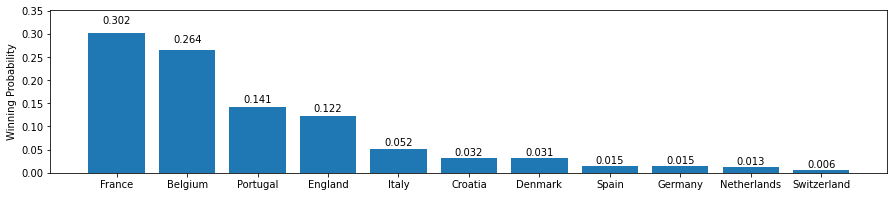

In [80]:
def build_figure_euro_winnner_distribution(hist, N, include_zero=True):

    for team in fifa_ranking.keys():
        if include_zero and team not in hist:
            hist[team] = 0
        
        if not include_zero and team in hist and hist[team]/N < 0.005:
            del hist[team]

    
    winners_table = [x for x in sorted(hist.items(), key=lambda x: (-x[1], x[0]))]
    
    teams = [x[0] for x in winners_table]
    win_ratio = [round(x[1]/N, 3) for x in winners_table]
    

    fig, ax = plt.subplots(figsize=[15, 3])
    bars = ax.bar(teams, win_ratio)
    ax.set_ylabel('Winning Probability')
    
    ax.set_ylim(0,max(win_ratio) + 0.05)
    
    def autolabel(rects, labels):
        """
        Attach a text label above each bar displaying its height
        """
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '{0:.3f}'.format(label),
                    ha='center', va='bottom')

    autolabel(bars, win_ratio)
    
    plt.show()
    
    
build_figure_euro_winnner_distribution(winners_hist, N, include_zero=False)